In [1]:
import findspark
findspark.init()

import os
PROJECT_HOME = os.path.abspath(os.curdir)
print(PROJECT_HOME)

import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

/home/noobcoder/0_Project/school/BigData/DemoNov29


In [2]:
pd.set_option('display.max_colwidth', 500)

In [3]:
SPARK_MASTER_HOST = os.environ.get('SPARK_MASTER_HOST', 'localhost')
sc = SparkSession.builder\
    .master(f'spark://{SPARK_MASTER_HOST}:7077')\
    .appName('Quiz04_4')\
    .config('spark.executor.memory', '512m')\
    .config('spark.jars.packages', 'julioasotodv:spark-tree-plotting:0.2')\
    .getOrCreate()

# Task 04: Classification with decision trees

## Load data

In [4]:
data = sc.read.csv(f'file://{PROJECT_HOME}/data/weather.csv', sep=',', inferSchema=True, header=True)
data.printSchema()
data.count()

root
 |-- outlook: string (nullable = true)
 |-- temperature: string (nullable = true)
 |-- humidity: string (nullable = true)
 |-- windy: boolean (nullable = true)
 |-- play: string (nullable = true)



14

## STRING INDEXER DATA

In [5]:
outlookIndexer = StringIndexer(inputCol='outlook', outputCol='outlook_idx').fit(data)
tempIndexer = StringIndexer(inputCol='temperature', outputCol='temp_idx').fit(data)
playIndexer = StringIndexer(inputCol='play', outputCol='play_idx').fit(data)

featureVectorer = VectorAssembler(
    inputCols=['outlook_idx', 'temp_idx', 'windy'],
    outputCol='featureIndexed'
)

## Decision Tree for weather data

In [6]:
tree = DecisionTreeClassifier(featuresCol='featureIndexed', labelCol='play_idx', maxBins=10)

## TRAIN MODEL

In [7]:
(training, testing) = data.randomSplit([0.7, 0.3])

pipeline = Pipeline(stages=[
    outlookIndexer,
    tempIndexer,
    playIndexer,
    featureVectorer,
    tree,
])

model = pipeline.fit(training)
predictions = model.transform(testing)

## SHOW PREDICTIONS

In [8]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="play_idx", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print (f"Test Error = { 1.0 - accuracy }")

predictions\
    .select(['play', 'play_idx', 'prediction'])\
    .show(10)

Test Error = 0.6666666666666667
+----+--------+----------+
|play|play_idx|prediction|
+----+--------+----------+
| yes|     0.0|       1.0|
| yes|     0.0|       0.0|
|  no|     1.0|       0.0|
+----+--------+----------+



DecisionTreeClassificationModel (uid=DecisionTreeClassifier_d62c0d2d435d) of depth 5 with 13 nodes
  If (feature 0 in {2.0})
   Predict: 0.0
  Else (feature 0 not in {2.0})
   If (feature 1 in {0.0,1.0})
    If (feature 0 in {0.0})
     If (feature 1 in {0.0})
      Predict: 0.0
     Else (feature 1 not in {0.0})
      Predict: 1.0
    Else (feature 0 not in {0.0})
     If (feature 1 in {1.0})
      Predict: 0.0
     Else (feature 1 not in {1.0})
      If (feature 2 <= 0.5)
       Predict: 1.0
      Else (feature 2 > 0.5)
       Predict: 0.0
   Else (feature 1 not in {0.0,1.0})
    Predict: 1.0



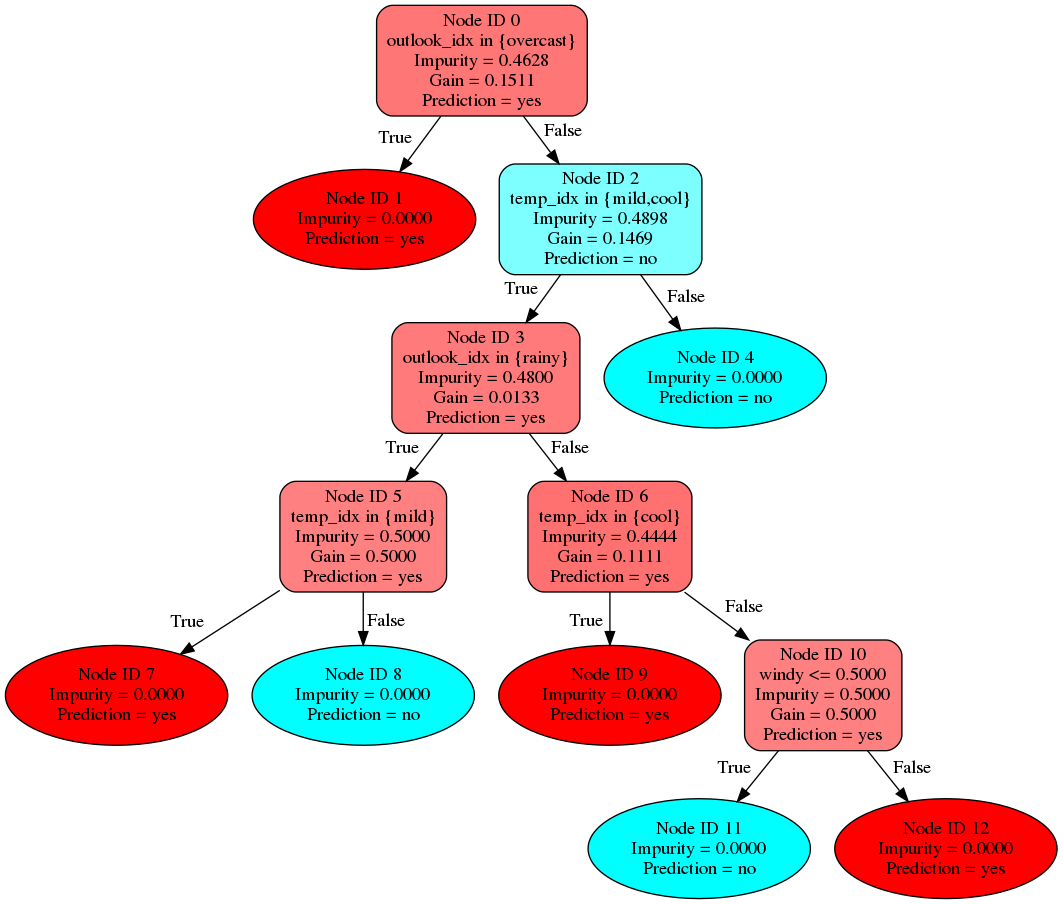

In [9]:
treeModel = model.stages[len(model.stages) - 1]
print (treeModel.toDebugString)
from spark_tree_plotting import plot_tree
png = plot_tree(
    treeModel,
    classNames=model.stages[2].labels,
    featureNames=['outlook_idx', 'temp_idx', 'windy'],
    categoryNames={
        'outlook_idx': model.stages[0].labels,
        'temp_idx': model.stages[1].labels,
    },
    filled=True,
    roundedCorners=True,
    roundLeaves=True
)

from IPython.display import Image
Image(png)